In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy as gp
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import anndata
import os

from gseapy.plot import barplot, dotplot
from collections import defaultdict
import anndataks

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children/paper_figures/final/modules') 
import YK_util, optimized_pair_comparison
from YK_util import *
from optimized_pair_comparison import *

In [4]:
# load data
path = '/home/yike/phd/dengue/data/mergedata_luca_NKT_202206.h5ad'
adata = sc.read_h5ad(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid, log1p=True) # log1p = 2
adata_kid = removegenes(adata_kid)
adata_kid = adata_kid[(adata_kid.obs.cell_subtype_new != 'doublets') & 
                        (adata_kid.obs.cell_subtype_new != 'unknown')].copy()
adata_kid = adata_kid[~ (adata_kid.obs['ID'] == '1_075_01')]

sc.pp.filter_genes(adata_kid, min_cells=3)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.var` of view, copying.
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [5]:
#rename and reorder some celltypes 
adata_kid = adata_kid.copy()
reorg_data(adata_kid) # 'cell_type_new', 'cell_subtype_new'

/home/yike/phd/dengue/dengue_children/paper_figures/final/modules/YK_util.py:172: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['cell_type_new'].cat.reorder_categories(group_order_primary, inplace=True)
/home/yike/phd/dengue/dengue_children/paper_figures/final/modules/YK_util.py:204: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['cell_subtype_new'].cat.reorder_categories(group_order_secondary, inplace=True)


In [6]:
#save path
save_figures = '/home/yike/phd/dengue/docs/paper_draft/figures/gseapy_pathway/'
save_tables = '/home/yike/phd/dengue/docs/paper_draft/tabels/gseapy/'

In [39]:
# get cell types and cell subtypes
cell_types = adata_kid.obs['cell_type_new'].unique().tolist()
cell_subtypes = adata_kid.obs['cell_subtype_new'].unique().tolist()

In [7]:
# load cell type palette
ct_palette = load_ct_palette()
print([ct for ct in ct_palette.keys()])
sns.color_palette(ct_palette.values())

['B cells', 'Plasmablasts', 'T cells', 'NK cells', 'Monocytes', 'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']


[(0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [8]:
# load cell subtype palette
cst_palette = load_cst_palette()
print([cst for cst in cst_palette.keys()])
sns.color_palette(cst_palette.values())

['memory B cells', 'naive B cells', 'activated B cells', 'proliferating plasmablasts', 'non-proliferating plasmablasts', 'CD4+ naive T cells', 'CD4+ memory T cells', 'CD8+ naive T cells', 'CD8+ effector memory T cells', 'CD8+ exhausted T cells', 'Tregs', 'MAIT', 'signaling NK cells', 'cytotoxic NK cells', 'proliferating NK cells', 'classical monocytes', 'non-classical monocytes', 'intermediate monocytes', 'cDC1', 'cDC2', 'pDCs', 'megakaryocytes']


[(1.0, 0.0, 0.0),
 (0.7372549019607844, 0.5607843137254902, 0.5607843137254902),
 (0.5019607843137255, 0.0, 0.0),
 (1.0, 0.8941176470588236, 0.7686274509803922),
 (1.0, 0.5490196078431373, 0.0),
 (0.6901960784313725, 0.7686274509803922, 0.8705882352941177),
 (0.4392156862745098, 0.5019607843137255, 0.5647058823529412),
 (0.0, 0.0, 0.5019607843137255),
 (0.2549019607843137, 0.4117647058823529, 0.8823529411764706),
 (0.0, 0.7490196078431373, 1.0),
 (0.0, 1.0, 1.0),
 (0.37254901960784315, 0.6196078431372549, 0.6274509803921569),
 (0.5019607843137255, 0.0, 0.5019607843137255),
 (0.8666666666666667, 0.6274509803921569, 0.8666666666666667),
 (1.0, 0.0, 1.0),
 (0.5607843137254902, 0.7372549019607844, 0.5607843137254902),
 (0.5647058823529412, 0.9333333333333333, 0.5647058823529412),
 (0.0, 0.5019607843137255, 0.0),
 (1.0, 0.7529411764705882, 0.796078431372549),
 (1.0, 0.0784313725490196, 0.5764705882352941),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [8]:
#open GO libraries
# gene_set_names = gp.get_library_name()
# 'GO_Biological_Process_2021'

In [11]:
SD_D=adata_kid[((adata_kid.obs.Condition=='S_dengue')|
            (adata_kid.obs.Condition=='dengue'))].copy()

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


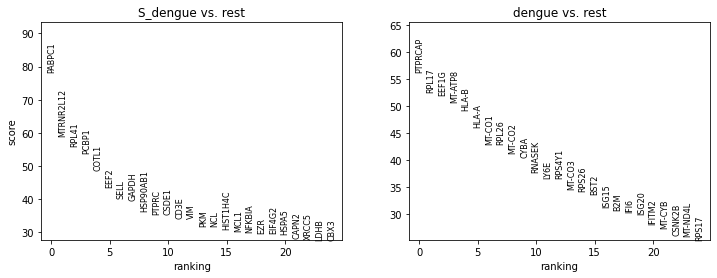

In [13]:
sc.tl.rank_genes_groups(SD_D, 'Condition', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(SD_D, n_genes=25, sharey=False, key="wilcoxon")

In [26]:
glist_SD = sc.get.rank_genes_groups_df(SD_D, group='S_dengue',
                                    key='wilcoxon', log2fc_min=1, 
                                    pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()

glist_D = sc.get.rank_genes_groups_df(SD_D, group='dengue',
                                    key='wilcoxon', log2fc_min=1, 
                                    pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()

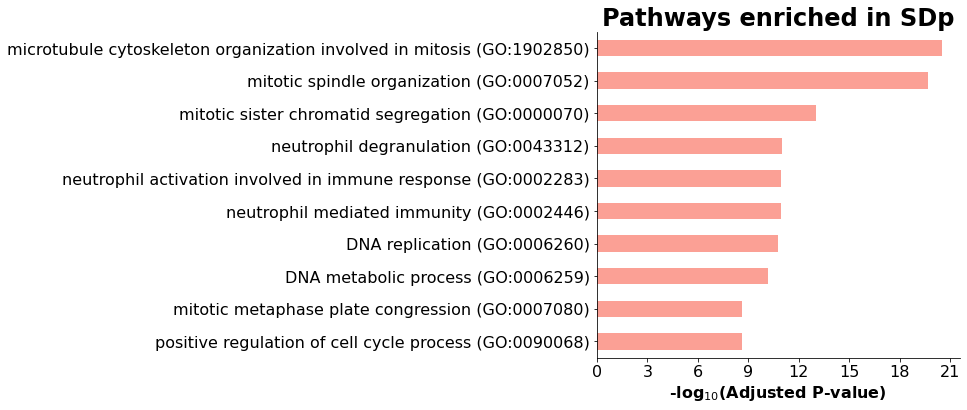

In [33]:
enr_res_SD = gp.enrichr(gene_list=glist_SD,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)
barplot(enr_res_SD.res2d,title='Pathways enriched in SDp')

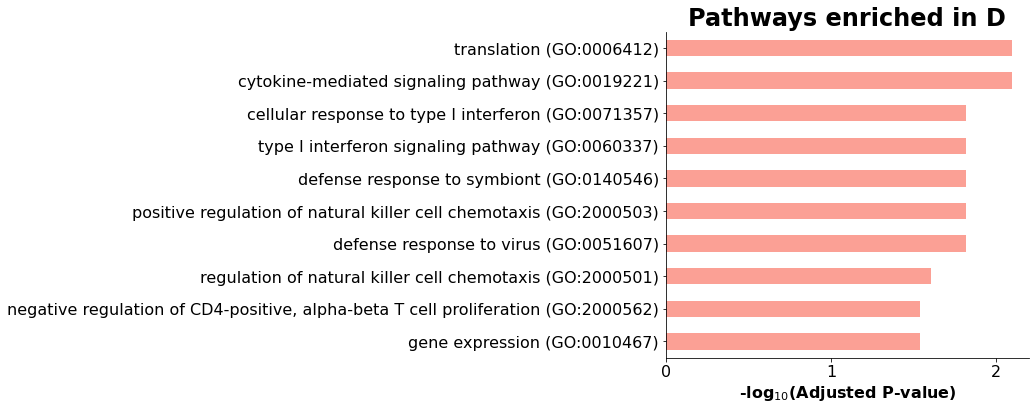

In [34]:
enr_res_D = gp.enrichr(gene_list=glist_D,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)
barplot(enr_res_D.res2d,title='Pathways enriched in D')

# myeloid cells (monocytes, cDCs) + plasmablasts

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.uns` of view, copying.


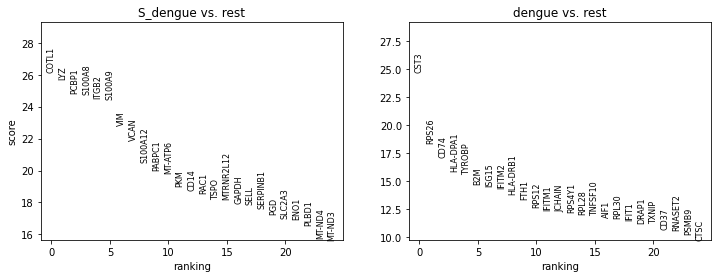

In [16]:
temp = adata_kid[adata_kid.obs['cell_type_new'].isin(['Monocytes', 'conventional DCs', 'plasmacytoid DCs'])]
SD_D = temp[temp.obs['Condition'].isin(['S_dengue', 'dengue'])]

sc.tl.rank_genes_groups(SD_D, 'Condition', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(SD_D, n_genes=25, sharey=False, key="wilcoxon")

glist_SD = sc.get.rank_genes_groups_df(SD_D, group='S_dengue',
                                    key='wilcoxon', log2fc_min=1, 
                                    pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()

In [17]:
enr_res_SD = gp.enrichr(gene_list=glist_SD,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)
enr_res_SD.res2d.to_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/gseapy/myeloid_SD_pathway.txt', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


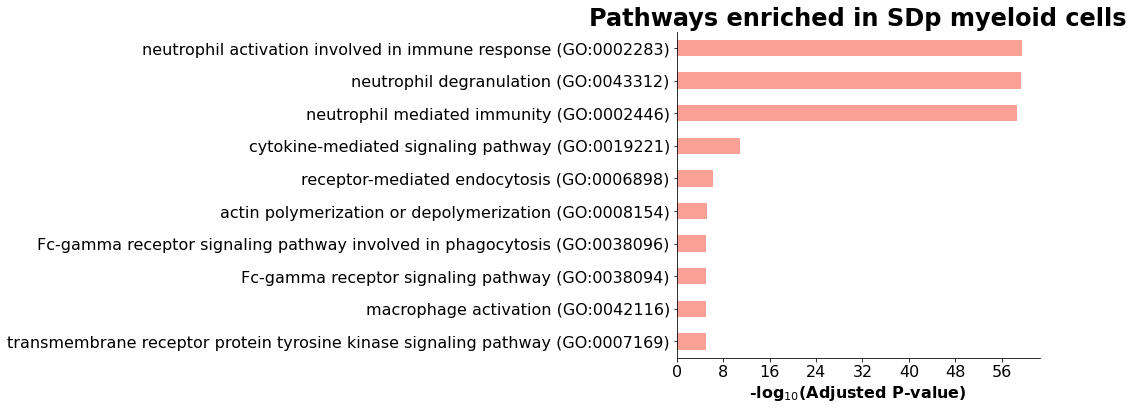

In [18]:
barplot(enr_res_SD.res2d,title='Pathways enriched in SDp myeloid cells')

# lymphocytes (NK, T, B)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.uns` of view, copying.


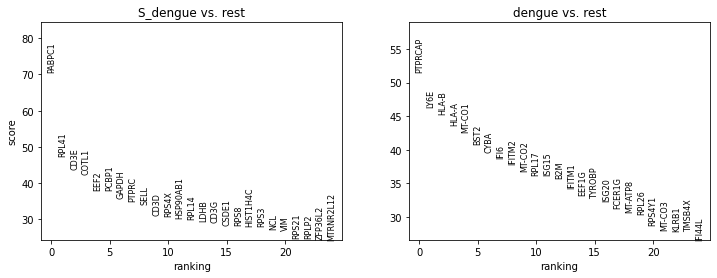

In [20]:
temp = adata_kid[adata_kid.obs['cell_type_new'].isin(['NK cells', 'T cells', 'B cells'])]
SD_D = temp[temp.obs['Condition'].isin(['S_dengue', 'dengue'])]

sc.tl.rank_genes_groups(SD_D, 'Condition', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(SD_D, n_genes=25, sharey=False, key="wilcoxon")

glist_SD = sc.get.rank_genes_groups_df(SD_D, group='S_dengue',
                                    key='wilcoxon', log2fc_min=1, 
                                    pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()

In [21]:
enr_res_SD = gp.enrichr(gene_list=glist_SD,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)
enr_res_SD.res2d.to_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/gseapy/lymphocyte_SD_pathway.txt', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


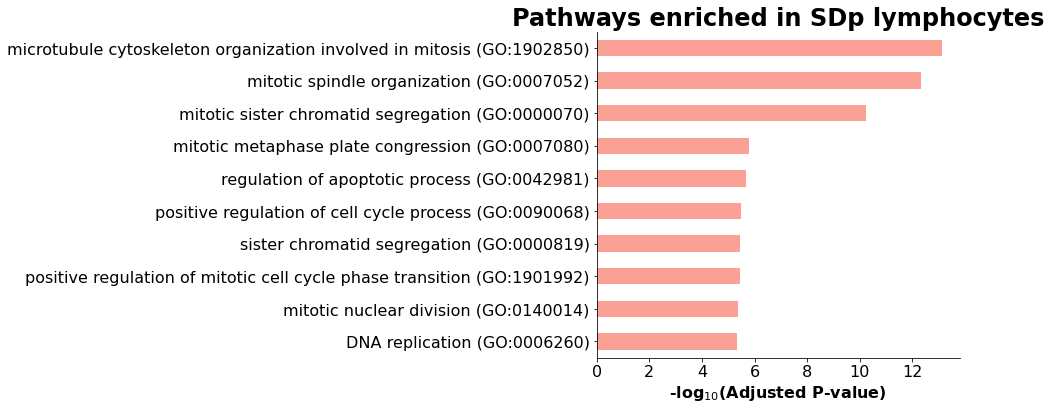

In [23]:
barplot(enr_res_SD.res2d,title='Pathways enriched in SDp lymphocytes')

# pathway analysis for distinct cell types using DEGs from pairwise comparison

In [9]:
def pathway_analysis(ct_pair, cts):    
    gene_ls1_up = ct_pair.loc[cts][ct_pair.loc[cts]['med_pair'] >= 1].reset_index()['gene']
    gene_ls2_up = gene_ls1_up[~ gene_ls1_up.str.startswith(('MT', 'RPL', 'RPS'))].unique().tolist()
    gene_ls1_up = gene_ls1_up.unique().tolist()

    gene_ls1_down = ct_pair.loc[cts][ct_pair.loc[cts]['med_pair'] <= -1].reset_index()['gene']
    gene_ls2_down = gene_ls1_down[~ gene_ls1_down.str.startswith(('MT', 'RPL', 'RPS'))].unique().tolist()
    gene_ls1_down = gene_ls1_down.unique().tolist()

    path = save_figures
    for ct in cts:
        path += ct.replace(' ', '_')

    if os.path.isdir(path) is False:
        os.makedirs(path)

    for gene_ls_group, trend in zip([[gene_ls1_up, gene_ls2_up], [gene_ls1_down, gene_ls2_down]], 
                                    ['upregulated', 'downregulated']):
        t_path = os.path.join(path, trend)
        if os.path.isdir(t_path) is False:
            os.makedirs(t_path)

        for gene_ls, name in zip(gene_ls_group, ['with_MT&LPS', 'without_MT&LPS']):

            pathway = gp.enrichr(gene_list=gene_ls,
                                 gene_sets=['GO_Biological_Process_2021'],
                                 description='pathway',
                                 cutoff=0.05,)
            barplot(pathway.res2d,title='Pathways {} in '.format(trend) + 'SDp', 
                   ofname=os.path.join(t_path, name + '.svg'))

            pathway.res2d.to_csv(os.path.join(t_path, name + '.tsv'), sep='\t', index=False)

In [11]:
ct_pair = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/exclude_1_075_01/ct_pair.tsv', sep=',', index_col=['cell_subtype', 'gene'])
for cts in [
    ['Monocytes'],
#     ['conventional DCs'],
    ['NK cells'],
#     ['T cells'],
#     ['B cells'],
#     ['Plasmablasts'],
]:
    pathway_analysis(ct_pair, cts)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [22]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children/paper_figures/final/modules') 
import YK_util, optimized_pair_comparison, functions_CCC_figure_fra_pair
from YK_util import *
from optimized_pair_comparison import *
from functions_CCC_figure_fra_pair import *

In [41]:
# do pairwise comparison on multiple cell_types for GSEAPY analysis
ct_obs='cell_type_new'
cd_SD=['S_dengue']
cd_D=['Dengue', 'DWS']
cell_types=[['Monocytes', 'concentional DCs'], ['NK cells', 'T cells'], cell_types]

pair_res = pair_comparison(adata_kid, ct_obs, 
                           cd_SD, cd_D, 
                           cell_types, gene_cut_off=False, log1p=2)

pair_res['pair_res'].to_csv(save_tables + 'pairwise_multi_cts.tsv')
pair_res['log_FCs'].to_csv(save_tables + 'pairwise_multi_cts.tsv')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

In [51]:
pair_res['pair_res']['cell_subtype'] = pair_res['pair_res']['cell_subtype'].replace({
    'Monocytes_concentional DCs_': 'APCs',
    'NK cells_T cells_': 'Lymphocytes',
    'B cells_NK cells_T cells_Monocytes_Plasmablasts_plasmacytoid DCs_conventional DCs_megakaryocytes_': 'PBMCs',
})

In [53]:
multi_ct_pair = pair_res['pair_res'].set_index(['cell_subtype', pair_res['pair_res'].index])
for cts in [
    ['APCs'],
    ['Lymphocytes'],
    ['PBMCs']
]:
    pathway_analysis(multi_ct_pair, cts)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

# volcano plot for PBMC DEGs and pathway analysis

In [83]:
# ks test
kid_D = adata_kid[adata_kid.obs['Condition'] == 'dengue']
kid_SD = adata_kid[adata_kid.obs['Condition'] == 'S_dengue']
ks_res = anndataks.compare(kid_D, kid_SD, 2)

# adjust pvalue
from statsmodels.stats.multitest import multipletests
adjust_pvalue = multipletests(ks_res['pvalue'], alpha=0.05, method='fdr_bh')[1] # pvals_corrected
ks_res['pvalue_corrected'] = adjust_pvalue

ks_res.to_csv(save_figures + 'PBMC_DGEs_D_SD.tsv', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [111]:
def volcano(data, ylim=200, xlim=3):
    data['-log10[pvalue]'] = -np.log10(data['pvalue_corrected'])

    req = ((data['log2_fold_change'] > 1) | (data['log2_fold_change'] < -1)) & (data['-log10[pvalue]'] > -np.log10(0.05))
    data.loc[(data['log2_fold_change'] > 1) & (data['-log10[pvalue]'] > -np.log10(0.05)), 'DEGs'] = 'Yes'
    data.loc[(data['log2_fold_change'] < -1) & (data['-log10[pvalue]'] > -np.log10(0.05)), 'DEGs'] = 'Yes'
    data.loc[~ req, 'DEGs'] = 'No'

#     rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    fig, ax = plt.subplots(figsize=(6,6))
    sns.set_style('ticks')
    sns.scatterplot(data=data, x='log2_fold_change', y='-log10[pvalue]', hue='DEGs', ax=ax, s=20, legend = False)

    for x, y, gene in zip(data[req]['log2_fold_change'], data[req]['-log10[pvalue]'], data[req].index):
        ax.text(x + 0.01, y + 0.1, gene, c='black', fontsize=6)

    ax.set(
        xlim=(-xlim, xlim),
        ylim=(-2, ylim),
    )

    ax.set_xlabel('log2 fold change', fontsize=10)
    ax.set_ylabel('-log10(pvalue)', fontsize=10)
#     ax.set_title('%s (XCL low NK cells vs XCL high NK cells)'%name.replace('_', ' '), fontsize=10)

    ax.axvline(1, zorder=-5, ls='--', c='gray', alpha=0.5, lw=0.5)
    ax.axvline(-1, zorder=-5, ls='--', c='gray', alpha=0.5, lw=0.5)
    ax.axhline(-np.log10(0.05), zorder=-5, ls='--', c='gray', alpha=0.5, lw=0.5)
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles=[], labels=None)
    fig.savefig(save_figures + 'volcano_D_SD.pdf')
    fig.savefig(save_figures + 'volcano_D_SD.png')
    
    return {'fig': fig, 'ax': ax}

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


{'fig': <Figure size 1800x1800 with 1 Axes>,
 'ax': <AxesSubplot:xlabel='log2 fold change', ylabel='-log10(pvalue)'>}

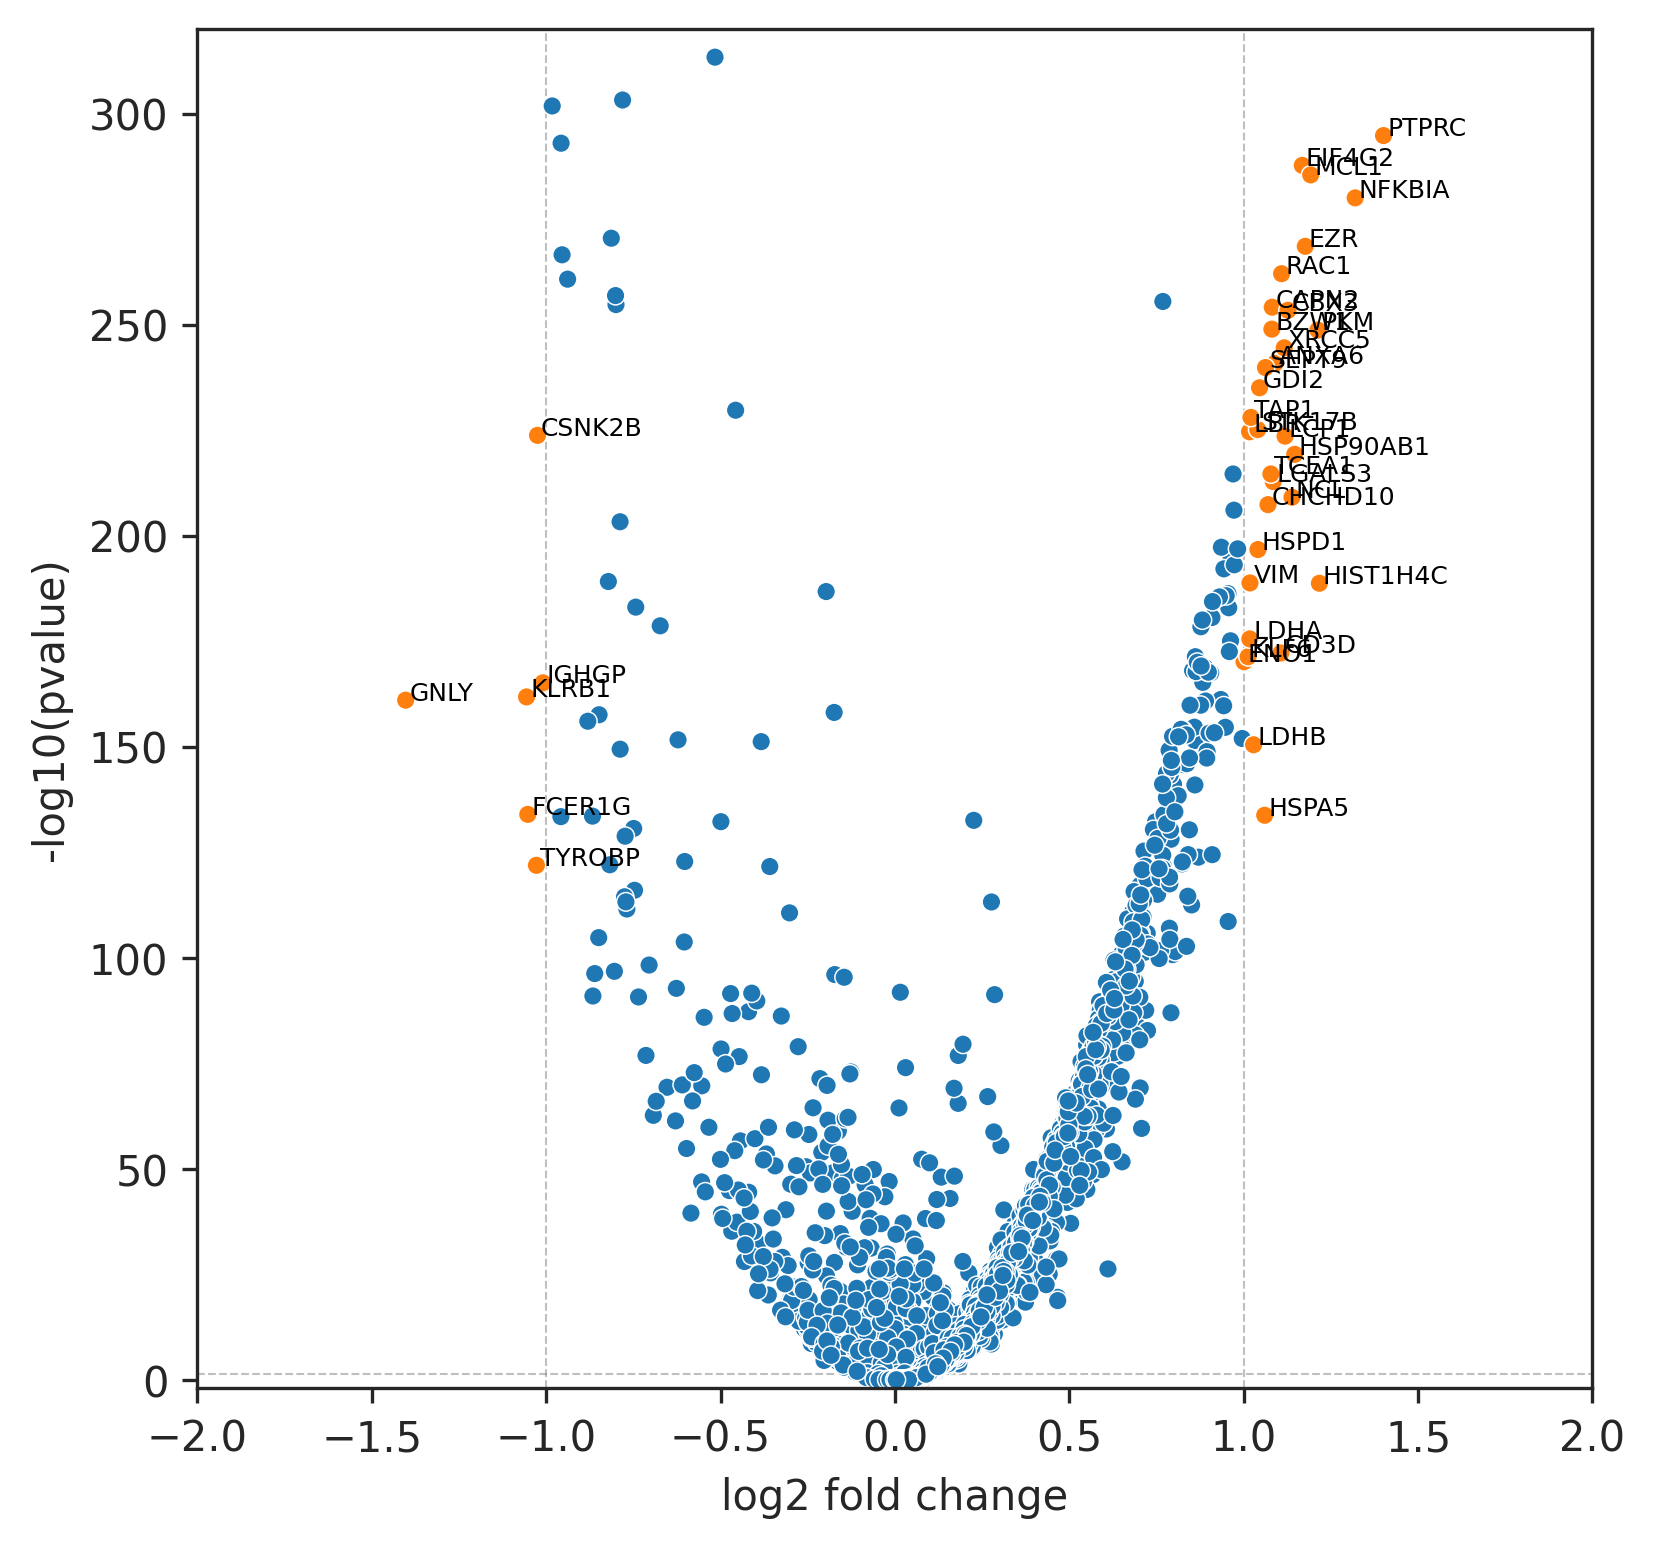

In [112]:
volcano(ks_res, ylim=320, xlim=2)

In [117]:
gene_SD = ks_res[(ks_res['log2_fold_change'] >=1) & (ks_res['pvalue_corrected'] < 0.05)].index
gene_SD2 = gene_SD[~ gene_SD.str.startswith(('MT', 'RPL', 'RPS'))].tolist()
gene_SD = gene_SD.tolist()

In [118]:
for gene_ls, name in zip([gene_SD, gene_SD2], ['with_MT&LPS', 'without_MT_LPS']):
    pathway = gp.enrichr(gene_list=gene_ls,
                                     gene_sets=['GO_Biological_Process_2021'],
                                     description='pathway',
                                     cutoff=0.05,)
    barplot(pathway.res2d,title='Pathways enriched in SDp', 
           ofname=os.path.join(save_figures, name + '.svg'))

    pathway.res2d.to_csv(os.path.join(save_figures, name + '.tsv'), sep='\t', index=False)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
